In [1]:
from utils import calculate_accuracy, f1_loss, infer, return_CAM, resume, return_CAM_VGG
from models import VGGClassifier, Classifier
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import seaborn as sb
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import torch.nn.functional as F

### Load Data

In [2]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225] ,inplace=True)
])
test_dataset = ImageFolder(root='./dataset/chest_xray/test/', transform = test_transform)

test_dataloader = DataLoader(test_dataset, shuffle = True, batch_size = 1)
data = enumerate(test_dataloader)

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

### CNN Network

In [3]:
model = Classifier()
model = resume(model, "models/cnn_model.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Classifier(
  (conv_1): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(12, 20, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv_3): Sequential(
    (0): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_4): Sequential(
    (0): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=34992, out_features=2, bias=True)
 

In [4]:
model.eval()
# print(f"Accuracy: {calculate_accuracy(model, test_dataloader)}") 
y_pred = []
y_true = []
for images,labels in test_dataloader:
    for i in range(len(labels)):
        img = images[i].view(1, 3, 224, 224)
        with torch.no_grad():
            logps = model(img.to(device))

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        y_pred.append(pred_label)
        y_true.append(labels.cpu()[i])
f1_score, precision, recall = f1_loss(torch.tensor(y_true), torch.tensor(y_pred))
f1_score, precision, recall

(tensor(0.8802), tensor(0.7992), tensor(0.9795))

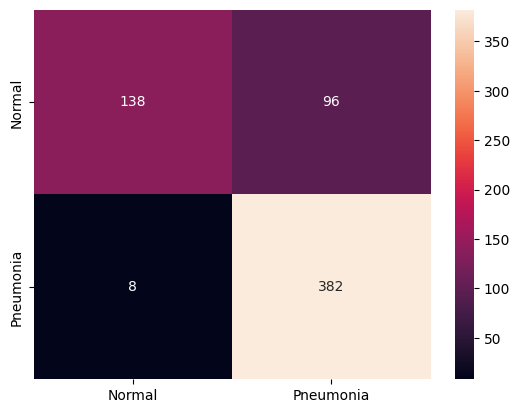

In [5]:
# confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Pneumonia']
df_cm = pd.DataFrame(cf_matrix, index = class_names, columns = class_names)
sb.heatmap(df_cm, annot=True, fmt="d")
plt.savefig("conv_net_confusion_matrix.pdf")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(1)


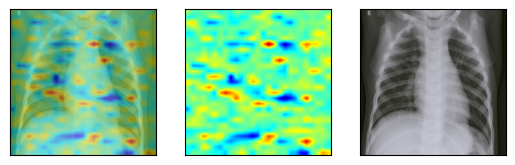

In [6]:
_, (example_data, target) = data.__next__()
example_data = example_data.to(device)
feature_map = model.get_feature_map(example_data)
pred = infer(model, example_data)
weights = model.fc[0].weight.data
cams = return_CAM(F.avg_pool2d(feature_map, 27), weights, pred, 27)
heat_map = cv2.applyColorMap(cv2.resize(cams[0],(224, 224)), cv2.COLORMAP_JET)
plt.subplot(1, 3, 1)
plt.imshow(0.5*(inv_normalize(example_data).detach().cpu())[0].permute(1, 2, 0) + 0.5 * (heat_map / 255))
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(heat_map)
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow((inv_normalize(example_data).cpu())[0].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])

print(pred[0])
plt.show()

## VGG-19

In [7]:
vgg_model = VGGClassifier()
vgg_model = resume(vgg_model, "./models/vgg_19_model.pth")
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg_model.to(device)

VGGClassifier(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [8]:
vgg_model.eval()
y_pred = []
y_true = []
for images,labels in test_dataloader:
    for i in range(len(labels)):
        img = images[i].view(1, 3, 224, 224)
        with torch.no_grad():
            logps = vgg_model(img.to(device))

        ps = torch.exp(logps)
        probab = list(ps.cpu()[0])
        pred_label = probab.index(max(probab))
        y_pred.append(pred_label)
        y_true.append(labels.cpu()[i])
f1_score, precision, recall = f1_loss(torch.tensor(y_true), torch.tensor(y_pred))
f1_score, precision, recall

(tensor(0.9002), tensor(0.8385), tensor(0.9718))

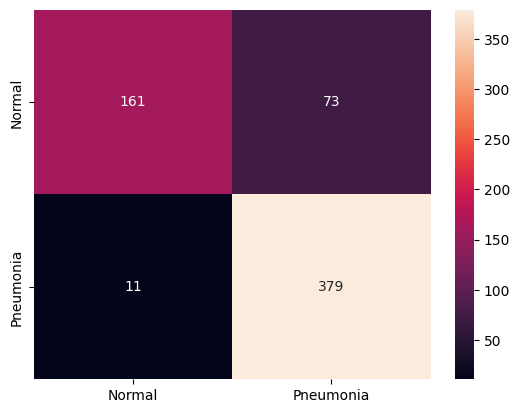

In [9]:
# confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['Normal', 'Pneumonia']
df_cm = pd.DataFrame(cf_matrix, index = class_names, columns = class_names)
sb.heatmap(df_cm, annot=True, fmt="d")
plt.savefig("conv_net_confusion_matrix.pdf")
plt.show()

In [10]:
data = enumerate(test_dataloader)
# model = resume(model, "best_model.pth")
_, (images, target) = data.__next__()
model_children = list(vgg_model.vgg19.children())
feature_extractor = model_children[0]
feature_map = feature_extractor(images.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


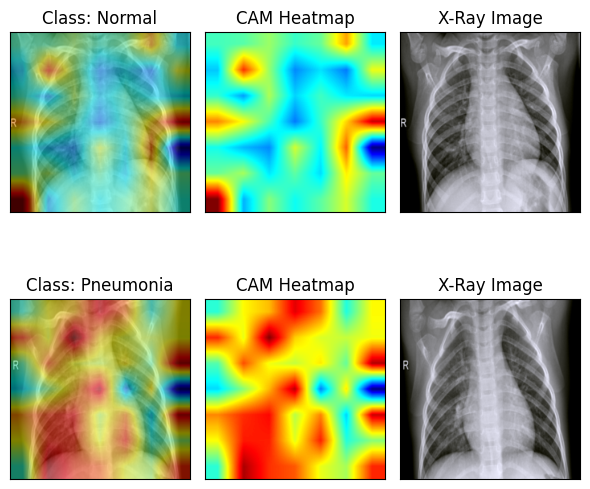

In [11]:
_, (example_data, target) = data.__next__()
classes = ['Normal', 'Pneumonia']
plt.figure(figsize = (6, 6))
rows = 2
for i in range(rows):
    feature_map = feature_extractor(example_data.to(device)).cpu()
    pred = infer(vgg_model, example_data.to(device)).cpu()
    weights = vgg_model.vgg19.classifier.weight.data.cpu()
    cams = return_CAM_VGG(F.avg_pool2d(feature_map, 7)[0].unsqueeze(0), weights, [pred[0]])
    heat_map = cv2.applyColorMap(cv2.resize(cams[0],(224, 224)), cv2.COLORMAP_JET)

    plt.subplot(rows, 3, 3 * i + 1)
    plt.imshow(0.5*inv_normalize(example_data[0]).permute(1, 2, 0) + 0.5 * (heat_map / 255))
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Class: {classes[pred[0].item()]}")

    plt.subplot(rows, 3, 3 * i + 2)
    plt.imshow(heat_map)
    plt.xticks([])
    plt.yticks([])
    plt.title("CAM Heatmap")

    plt.subplot(rows, 3, 3 * i + 3)
    plt.imshow(inv_normalize(example_data[0]).permute(1, 2, 0))
    plt.xticks([])
    plt.yticks([])
    plt.title("X-Ray Image")

    _, (example_data, target) = data.__next__()

plt.tight_layout()
plt.savefig("CAM Image CNN.pdf")
plt.show()